# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [DUBOUX Jean-Paul]([link](https://github.com/Eclil))
- [WANG Céline]([link](https://github.com/cessounette))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [19]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

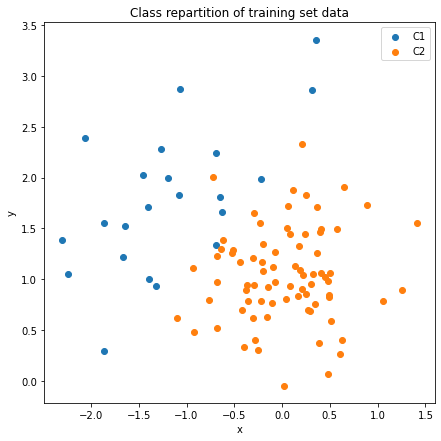

In [20]:
# your code

import matplotlib.pyplot as plt
import numpy as np

# load the training set
train = np.loadtxt('data/synth_train.txt') 
class_train = train[:,0]
x_train = train[:,1:]

N_train = train.shape[0]

# load the test set
test = np.loadtxt('data/synth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]


plt.figure(figsize=(7,7))
class_train_1 = x_train[class_train[:] == 1]
class_train_2 = x_train[class_train[:] == 2]

plt.scatter(class_train_1[:,0],class_train_1[:,1])
plt.scatter(class_train_2[:,0],class_train_2[:,1])

plt.xlabel('x')
plt.ylabel('y')
plt.legend(['C1','C2'])
plt.title('Class repartition of training set data')

plt.show()

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).

**Answer:**

In [21]:
# your code
from numpy import linalg as LA

def k_NN_classif(train_set, test_set, k):
    class_pred = []
    for point in test_set:
        train_coord = train_set[:,1:]
        dist_list = LA.norm(train_coord - point, axis = 1)

        dist_list = np.array(dist_list)
        ind_list = np.argsort(dist_list)

        class_neigh = train_set[:,0][ind_list[:k]].astype("int")

        count = np.bincount(class_neigh)

        class_pred.append(np.argmax(count))

    return np.array(class_pred)
    

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

[0.065, 0.06, 0.045, 0.05, 0.06, 0.055, 0.07, 0.07, 0.075, 0.075, 0.09, 0.075, 0.08, 0.075, 0.075, 0.075, 0.08, 0.08, 0.08, 0.08]


<function matplotlib.pyplot.show(close=None, block=None)>

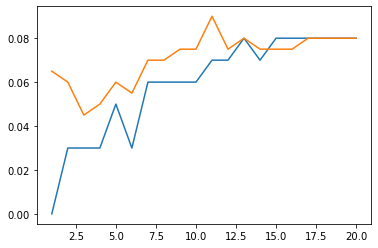

In [22]:
# your code

# train
freq_list = []
for i in range (1,21):
    L = k_NN_classif(train,x_train,i)
    L = [int(L[k] - class_train[k]) for k in range (len(L))]
    freq_list.append((len(L) - L.count(0))/len(L))

freq_list

plt.figure()
plt.plot(np.linspace(1,20,20),freq_list)

# test
freq_list2 = []
for i in range (1,21):
    L = k_NN_classif(train,x_test,i)
    L = [int(L[k] - np.array(test[k,0])) for k in range (len(L))]
    freq_list2.append((len(L) - L.count(0))/len(L))

print(freq_list2)

plt.plot(np.linspace(1,20,20),freq_list2)
plt.show


4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**  According to the results, K = 3 seems the optimal value both for the training and testing sets (K = 1 doesn't represent anything for the training set, hence the perfect yet useless results).

Text(0.5, 1.0, 'Class repartition of testing set data')

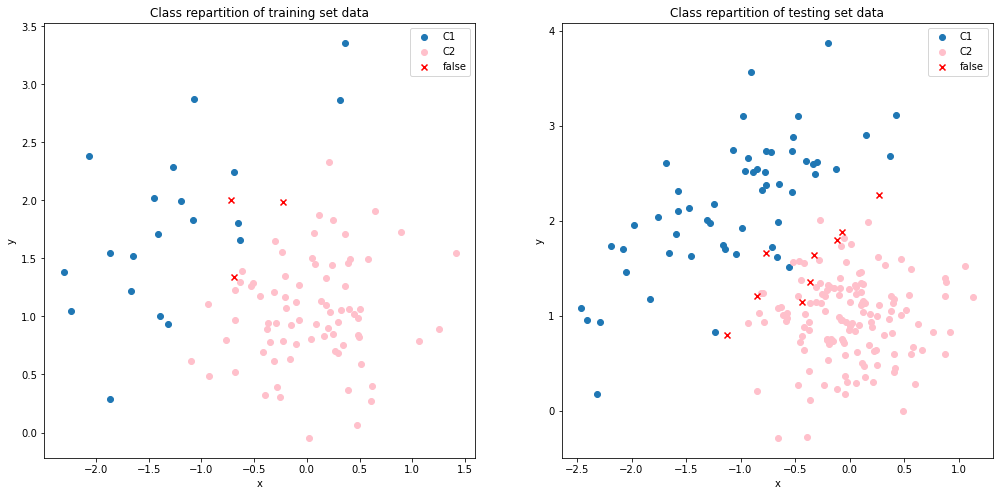

In [23]:
# your code

plt.figure(figsize=(17,8))

## TRAIN CASE
Ltrain = k_NN_classif(train,x_train,3)

class_train_1_k3 = x_train[(class_train == 1) & (Ltrain == class_train)]
class_train_2_k3 = x_train[(class_train == 2) & (Ltrain == class_train)]
class_train_false_k3 = x_train[Ltrain != class_train]

plt.subplot(1,2,1)

plt.scatter(class_train_1_k3[:,0],class_train_1_k3[:,1])
plt.scatter(class_train_2_k3[:,0],class_train_2_k3[:,1],color='pink')
plt.scatter(class_train_false_k3[:,0],class_train_false_k3[:,1],color='r',marker='x')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(['C1','C2','false'])
plt.title('Class repartition of training set data')



## TEST CASE
Ltest = k_NN_classif(train,x_test,3)

class_test_1_k3 = x_test[(test[:,0] == 1) & (Ltest == test[:,0])]
class_test_2_k3 = x_test[(test[:,0] == 2) & (Ltest == test[:,0])]
class_test_false_k3 = x_test[Ltest != test[:,0]]

plt.subplot(1,2,2)

plt.scatter(class_test_1_k3[:,0],class_test_1_k3[:,1])
plt.scatter(class_test_2_k3[:,0],class_test_2_k3[:,1],color='pink')
plt.scatter(class_test_false_k3[:,0],class_test_false_k3[:,1],color='r',marker='x')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(['C1','C2','false'])
plt.title('Class repartition of testing set data')

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

[0.065, 0.06, 0.045, 0.05, 0.06, 0.055, 0.07, 0.07, 0.075, 0.075, 0.09, 0.075, 0.08, 0.075, 0.075, 0.075, 0.08, 0.08, 0.08, 0.08]


<function matplotlib.pyplot.show(close=None, block=None)>

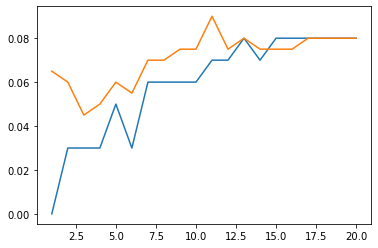

In [24]:
# your code
import timeit
from sklearn.neighbors import KNeighborsClassifier

freq_list = []

for k in range (1,21):
    neighbors = KNeighborsClassifier(k)
    neighbors.fit(x_train,class_train)
    L = neighbors.predict(x_train)
    L = [int(L[k] - class_train[k]) for k in range (len(L))]
    freq_list.append((len(L) - L.count(0))/len(L))

plt.figure()
plt.plot(np.linspace(1,20,20),freq_list)

freq_list2 = []

for k in range (1,21):
    neighbors = KNeighborsClassifier(k)
    neighbors.fit(x_train,class_train)
    L = neighbors.predict(x_test)
    L = [int(L[k] - np.array(test[k,0])) for k in range (len(L))]
    freq_list2.append((len(L) - L.count(0))/len(L))

print(freq_list2)

plt.plot(np.linspace(1,20,20),freq_list2)
plt.show

In [25]:
%%timeit -r 10

L = k_NN_classif(train,x_train,3)

5.04 ms ± 1.83 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [26]:
%%timeit -r 10

neighbors = KNeighborsClassifier(3)
neighbors.fit(x_train, class_train)
neighbors.predict(x_train)

5.67 ms ± 332 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

<function matplotlib.pyplot.show(close=None, block=None)>

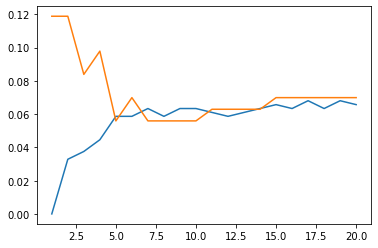

In [27]:
# your code
import sklearn.model_selection
np.random.seed(12345)
dataBCW = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
trainBCW,testBCW = sklearn.model_selection.train_test_split(dataBCW)

trainBCW,testBCW = trainBCW[:,1:], testBCW[:,1:] 
x_trainBCW, x_testBCW = trainBCW[:,1:], testBCW[:,1:]
class_trainBCW, class_testBCW = trainBCW[:,0], testBCW[:,0]

# train
freq_listBCW_mean = np.zeros(20)
for index in range (30):
    for i in range (20):
        L1BCW = k_NN_classif(trainBCW,x_trainBCW,i+1)
        L1BCW = [int(L1BCW[k] - class_trainBCW[k]) for k in range (len(L1BCW))]
        freq_listBCW_mean[i] += (len(L1BCW) - L1BCW.count(0))/(len(L1BCW)*30)

plt.figure()
plt.plot(np.linspace(1,20,20),freq_listBCW_mean)

# test
freq_list2BCW_mean = np.zeros(20)
for index in range(30):
    for i in range (0,20):
        L2BCW = k_NN_classif(trainBCW,x_testBCW,i+1)
        L2BCW = [int(L2BCW[k] - np.array(testBCW[k,0])) for k in range (len(L2BCW))]
        freq_list2BCW_mean[i] += (len(L2BCW) - L2BCW.count(0))/(len(L2BCW)*30)


plt.plot(np.linspace(1,20,20),freq_list2BCW_mean)
plt.show


Text(0.5, 1.0, 'Class repartition of testing set data')

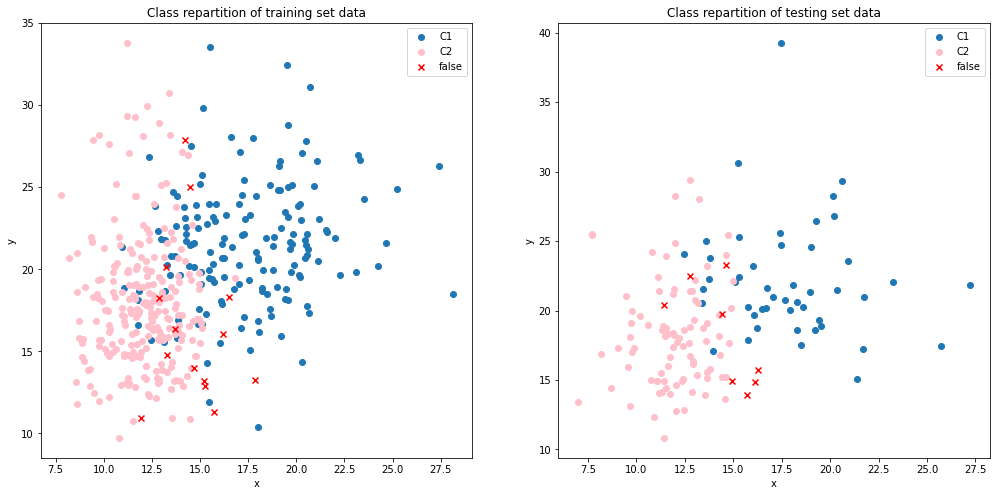

In [28]:
## TRAIN CASE
K = 2

plt.figure(figsize=(17,8))
LtrainBCW = k_NN_classif(trainBCW,x_trainBCW,2)

class_train_1_k3BCW = x_trainBCW[(class_trainBCW == 1) & (LtrainBCW == class_trainBCW)]
class_train_2_k3BCW = x_trainBCW[(class_trainBCW == 2) & (LtrainBCW == class_trainBCW)]
class_train_false_k3BCW = x_trainBCW[LtrainBCW != class_trainBCW]

plt.subplot(1,2,1)

plt.scatter(class_train_1_k3BCW[:,0],class_train_1_k3BCW[:,1])
plt.scatter(class_train_2_k3BCW[:,0],class_train_2_k3BCW[:,1],color='pink')
plt.scatter(class_train_false_k3BCW[:,0],class_train_false_k3BCW[:,1],color='r',marker='x')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(['C1','C2','false'])
plt.title('Class repartition of training set data')



## TEST CASE
K = 5
LtestBCW = k_NN_classif(trainBCW,x_testBCW,K)

class_test_1_k3BCW = x_testBCW[(testBCW[:,0] == 1) & (LtestBCW == testBCW[:,0])]
class_test_2_k3BCW = x_testBCW[(testBCW[:,0] == 2) & (LtestBCW == testBCW[:,0])]
class_test_false_k3BCW = x_testBCW[LtestBCW != testBCW[:,0]]

plt.subplot(1,2,2)

plt.scatter(class_test_1_k3BCW[:,0],class_test_1_k3BCW[:,1])
plt.scatter(class_test_2_k3BCW[:,0],class_test_2_k3BCW[:,1],color='pink')
plt.scatter(class_test_false_k3BCW[:,0],class_test_false_k3BCW[:,1],color='r',marker='x')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(['C1','C2','false'])
plt.title('Class repartition of testing set data')

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [29]:
!cd example_cy && python setup.py build_ext --inplace

running build_ext


In [30]:
import example_cy.example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [31]:
# your code

import example_cy.example_cy.primes as toy

print(toy.cprimes(50))

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229]
None


3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [32]:
# your code
import example_cy.example_cy.kNN as kNN

# load the training set
train = np.loadtxt('./data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0].astype(int)
x_train = train[:,1:]
N_train = train.shape[0]

# load the test set
test = np.loadtxt('./data/synth_test.txt') 
class_test = test[:,0].astype(int)
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]

pred = kNN.kNN(class_train, x_train, x_train, 1)
np.array_equal(pred, class_train)

True

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [33]:
%%timeit -r 10

K = 3
kNN.kNN(class_train, x_train, x_test, 3)

13.4 ms ± 1.61 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [34]:
M = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
XDh = np.diff(M)
N = np.zeros(len(M))


XDh = np.concatenate((XDh.T,N[np.newaxis,:]))
XDh.T

array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.]])

In [35]:
# your code
import time
from numba import jit

@jit(nopython=True)
def gradient2D (X):

    assert len(np.shape(X)) <= 2, "Matrix dimension is above 2 !"
    
    XDh = np.diff(X)
    DvX = np.diff(X.T).T

    if(np.shape(XDh)[0] != 0):
        N = np.zeros((len(XDh),len(XDh[0])+1))
        N2 = np.zeros((len(DvX)+1,len(DvX[0])))
        for i in range (len(XDh)):
            for j in range (len(DvX)):
                N[i][j] = XDh[i][j]
                N2[i][j] = DvX.T[i][j]
    else: # 1x1 matrix case
        XDh = [0]
        DvX = [0]
    D = (N,N2.T)
    return D

def tv(X):
    """_summary_ 
    Compute the discrete isotopic total variation of a complex matrix.

    Args:
        X (np.array): a matrix of complex values.

    Returns:
        TV (complex): the discrete isotopic total variation of X.
    """
    D = gradient2D(X)

    XDh = D[0]
    DvX = D[1]

    TV = 0

    for i in range(len(X)) :
        for j in range(len(X[0])) :
            TV += np.sqrt(XDh[i][j]**2 + DvX[i][j]**2)

    return TV


2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [45]:
%%timeit -r 10

M = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
tv(M)

40.2 µs ± 1.76 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [43]:
# your code

def gradient2Dbasic (X):

    assert len(np.shape(X)) <= 2, "Matrix dimension is above 2 !"
    
    XDh = np.diff(X)
    DvX = np.diff(X.T).T

    if(np.shape(XDh)[0] != 0):
        N = np.zeros((len(XDh),len(XDh[0])+1))
        N2 = np.zeros((len(DvX)+1,len(DvX[0])))
        for i in range (len(XDh)):
            for j in range (len(DvX)):
                N[i][j] = XDh[i][j]
                N2[i][j] = DvX.T[i][j]
    else: # 1x1 matrix case
        XDh = [0]
        DvX = [0]
    D = (N,N2.T)
    return D

def tvbasic(X):
    """_summary_ 
    Compute the discrete isotopic total variation of a complex matrix.

    Args:
        X (np.array): a matrix of complex values.

    Returns:
        TV (complex): the discrete isotopic total variation of X.
    """
    D = gradient2Dbasic(X)

    XDh = D[0]
    DvX = D[1]

    TV = 0

    for i in range(len(X)) :
        for j in range(len(X[0])) :
            TV += np.sqrt(XDh[i][j]**2 + DvX[i][j]**2)

    return TV


In [46]:
%%timeit -r 10

M = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
tvbasic(M)

72.3 µs ± 6.03 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
